# Modelos de regresión logística

![BLR](https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg)

En el tema anterior vimos modelos de regresión lineal para modelar variables de comportamiento continuo en relación a otras. En nuestro qué hacer como científicos de datos hay muchos problemas que, por el contrario, se modelan con una variable tipo Bernoulli (solo dos posibilidades, éxito (1) o fracaso (0)). 

En estos contextos, el uso de clasificadores es el apropiado. En este sentido, en esta clase revisaremos cómo implementar un modelo de regresión logística Bayesiana usando PyMC.

> **Objetivos:**
> - Implementar modelos de regresión logística Bayesiana usando PyMC.

> **Referencias:**
> 
> - https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/
> - https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16
> - https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

## 1. Descripción del problema

Un banco quiere encontrar cómo mejorar sus estrategias para la siguiente campaña publicitaria. Para esto tenemos datos de campaña(s) publicitaria(s) pasada(s) que se espera que analicemos para encontrar patrones que nos ayuden a encontar ideas para desarrollar futuras estrategias publicitarias.

La campaña publicitaria en cuestión es para que los clientes hagan un depósito a término. Un depósito a término es un depósito en un banco, por el cual el banco ofrece una tasa fija, la cuál será entregada cuando se cumpla el término específico del depósito.

Los atributos de nuestro conjunto de datos son:

1. Datos del cliente:

- age: (numérica)
- job: tipo de trabajo (categórica: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital: estado marital (categórica: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
- education: (categórica: primary, secondary, tertiary and unknown)
- default: tiene créditos sin pagar? (categórica: 'no', 'yes', 'unknown')
- housing: tiene préstamo hipotecario? (categórica: 'no', 'yes', 'unknown')
- loan: tiene préstamo personal? (categórica: 'no', 'yes', 'unknown')
- balance: balance en su(s) cuenta(s) bancarias.

2. Datos de la campaña publicitaria actual:

- contact: forma de contacto (categórica: 'cellular','telephone')
- month: último mes de contacto en el año (categórica: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day: último día de contacto de la semana (categórica: 'mon', 'tue', 'wed', 'thu', 'fri')
- duration: duración del último contacto (numérica). Nota importante: este atributo afecta fuertemente la salida (por ejemplo, si duration=0, entonces y=deposit='no'). Sin embargo, la duración no se sabe antes de que una llamada sea llevada a cabo. También, al final de la llamada y=deposit es obviamente conocida. Por tanto, este atributo debería ser descartado para propósitos de un modelo predictivo.

3. Otros datos:

- campaign: número de contactos llevados a cabo durante la campaña (numérica)
- pdays: número de días que pasaron después de que el cliente fue contactado en una campaña previa (numérica; -1 significa que el cliente no fue contactado previamente)
- previous: número de contactos llevados a cabo antes de esta campaña (numérica)
- poutcome: resultado de la campaña previa (categórica: 'failure', 'unknown', 'success', 'other')


Veamos los datos.

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer el archivo de datos (bank.csv)
df = pd.read_csv("data/bank.csv")

In [3]:
# Cabecera del archivo
df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
6544,38,services,single,secondary,no,0,yes,no,unknown,27,may,166,2,-1,0,unknown,no
720,44,technician,single,secondary,no,7138,no,no,cellular,8,aug,809,2,-1,0,unknown,yes
5768,55,retired,married,primary,no,2,no,no,unknown,27,jun,392,4,-1,0,unknown,no
9359,33,services,married,secondary,no,1082,yes,yes,cellular,19,nov,351,1,-1,0,unknown,no
10155,29,technician,married,tertiary,no,1489,yes,no,unknown,28,may,430,1,-1,0,unknown,no
264,55,blue-collar,married,unknown,no,7561,no,no,unknown,6,jun,685,3,-1,0,unknown,yes
11087,40,technician,single,tertiary,no,47,yes,no,cellular,5,may,159,1,365,1,failure,no
9941,32,management,single,tertiary,no,316,yes,no,cellular,29,jan,215,3,-1,0,unknown,no
10391,40,technician,married,secondary,no,1270,no,no,cellular,17,apr,342,2,-1,0,unknown,no
1949,38,blue-collar,divorced,primary,no,0,yes,no,cellular,13,may,531,2,-1,0,unknown,yes


In [4]:
# Descripción de columnas numéricas
df.describe(include="number")

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [5]:
# Descripción de columnas categóricas
df.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,5881,9702,8042,2824,8326,5873


## 2. Análisis exploratorio de datos

Antes de proponer algún modelo es importante que nos demos una idea intuitiva de cómo se relacionan los atributos entre sí. Para esto es muy importante realizar un análisis exploratorio de datos.

En este caso haremos un análisis simple, explorando las relaciones entre cada variable y la salida.

In [6]:
# Importar pyplot
from matplotlib import pyplot as plt
# Importar seaborn
import seaborn as sns

Antes de revisar la relación entre variables, veamos la variable de salida:

<Axes: xlabel='deposit'>

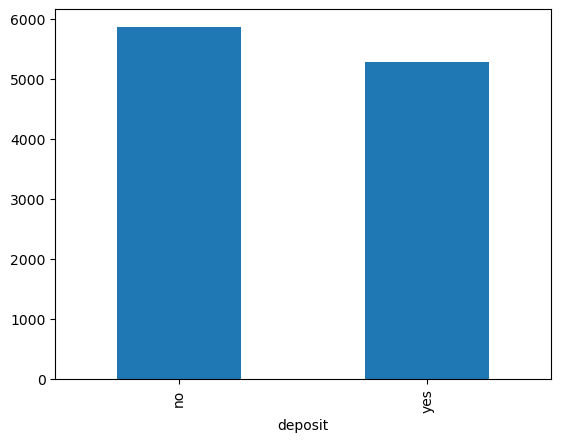

In [7]:
# Histograma de depósitos
df["deposit"].value_counts().plot(kind="bar")

Vemos que está prácticamente balanceada.

### Variables numéricas

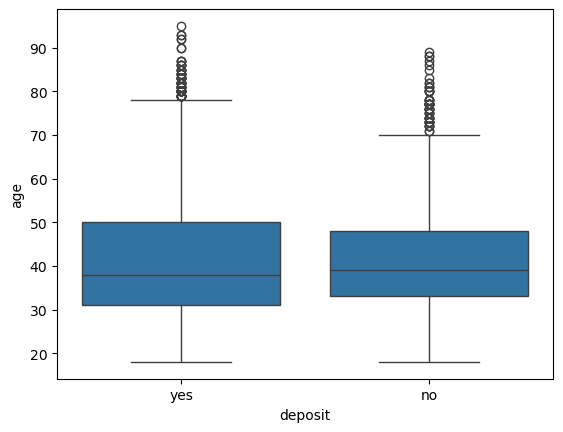

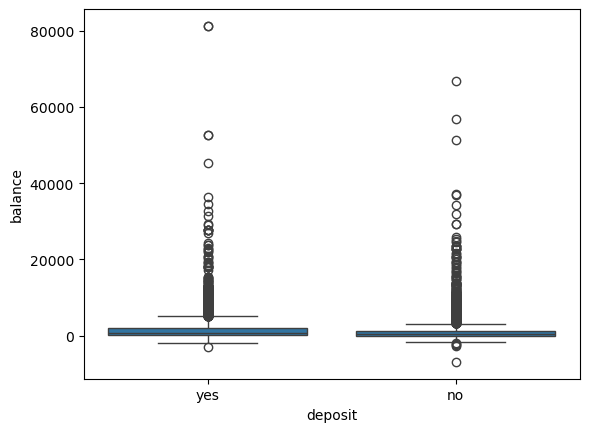

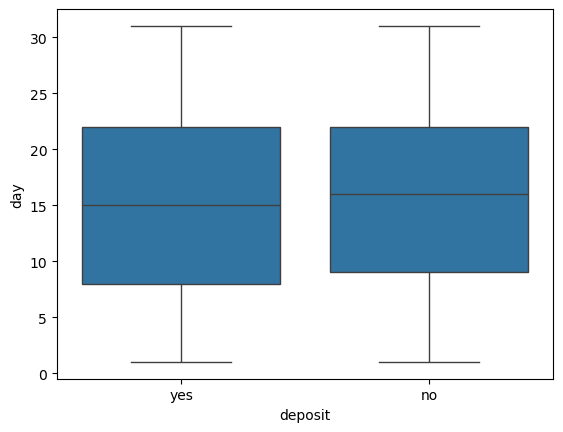

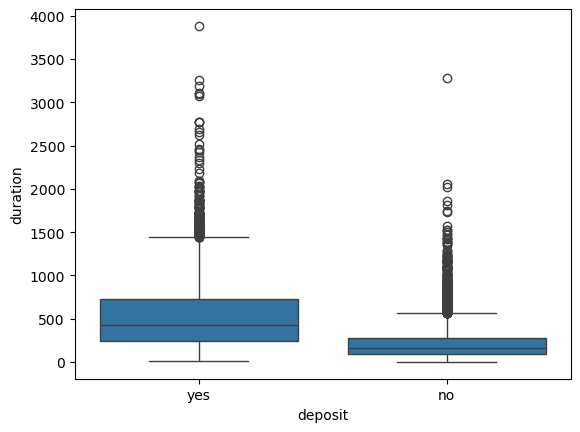

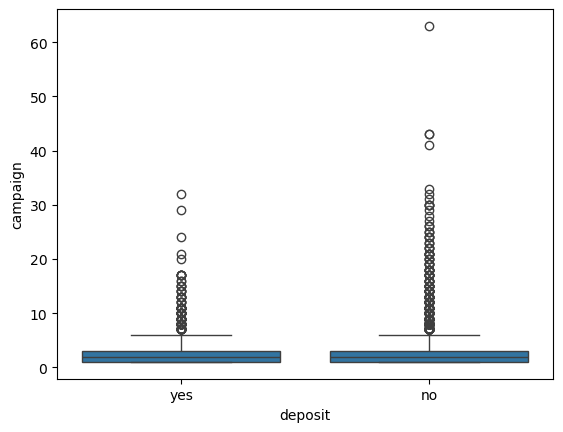

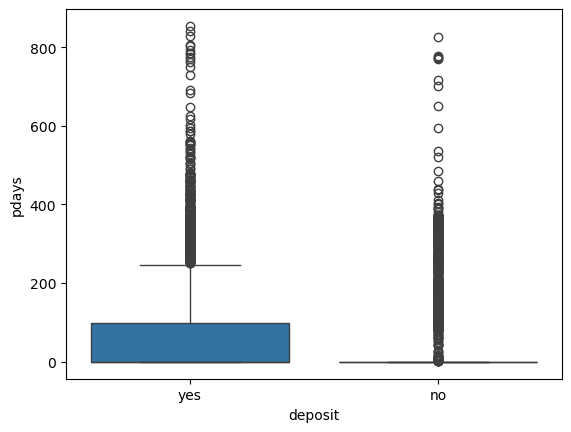

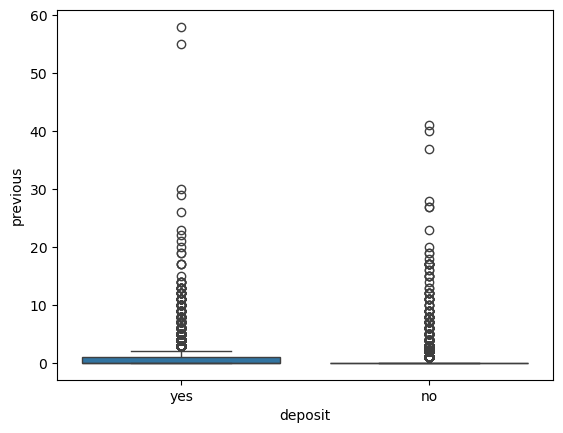

In [8]:
# Boxplot de las columnas numéricas, agrupado por la columna "deposit"
for col in df.select_dtypes(include="number"):
    sns.boxplot(x="deposit", y=col, data=df)
    plt.show()

Veamos un poco más de cerca el balance:

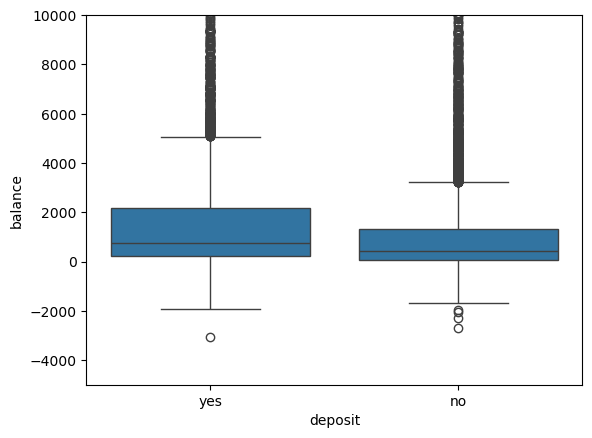

In [9]:
# Boxplot de la columna de balance, agrupado por la columna "deposit", acercado
sns.boxplot(x="deposit", y="balance", data=df)
plt.ylim(-5000, 10000)
plt.show()

#### Conclusión:

De las variables numéricas, las que parecen tener una relación directa con nuestro objetivo son:

- balance
- duration (esta no la debemos incluir en un modelo predictivo, por las razones antes expuestas)
- pdays
- previous

### Variables categóricas

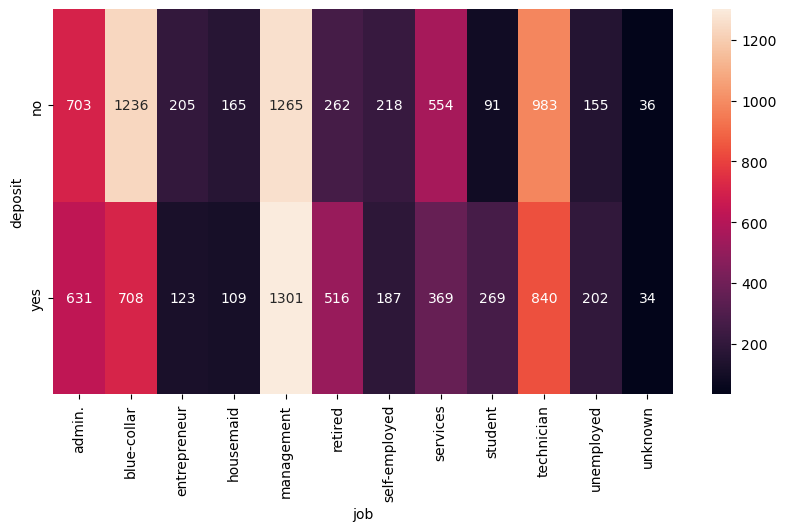

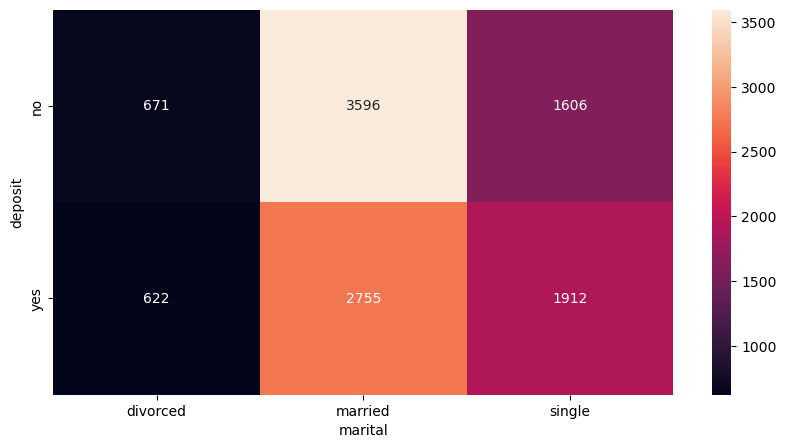

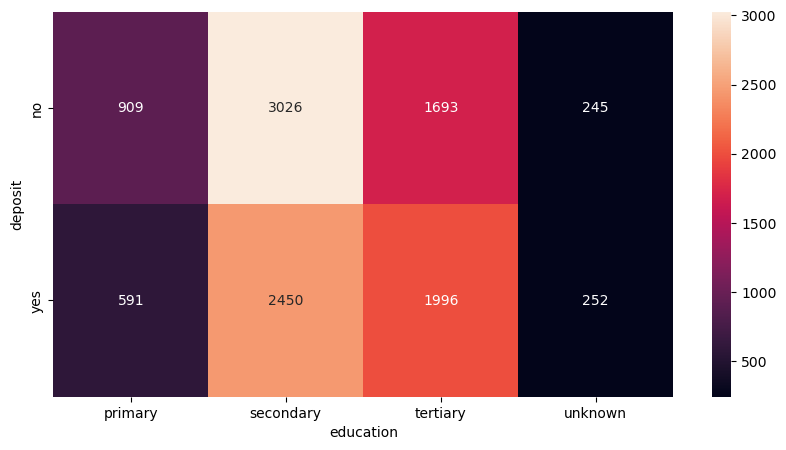

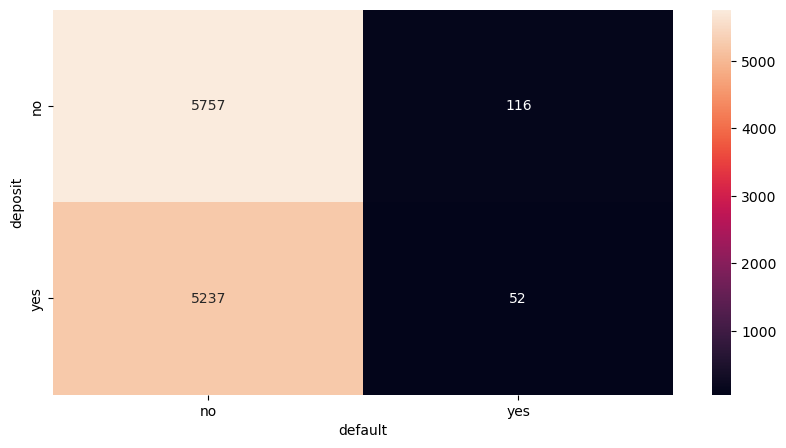

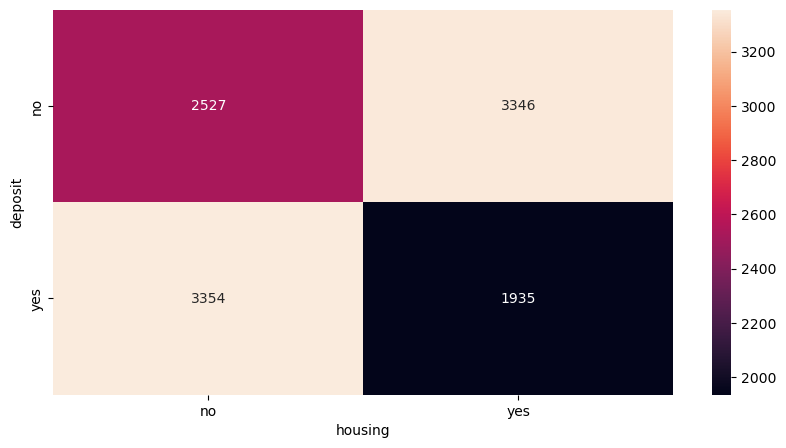

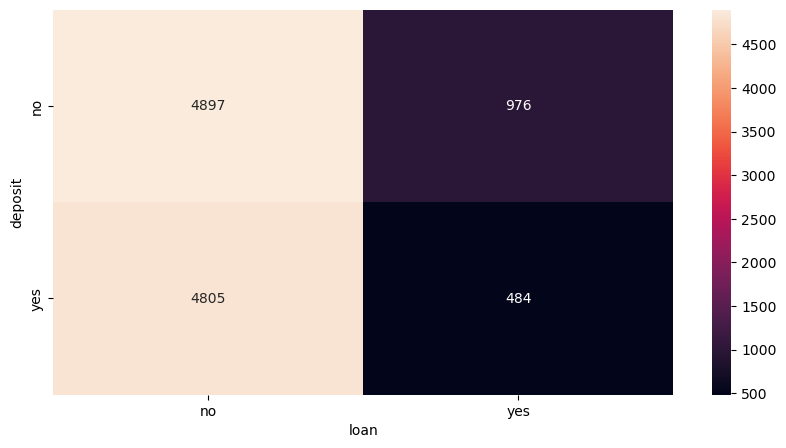

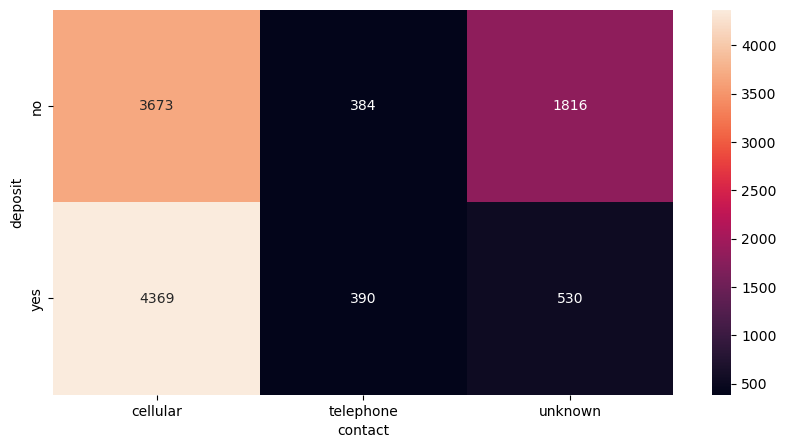

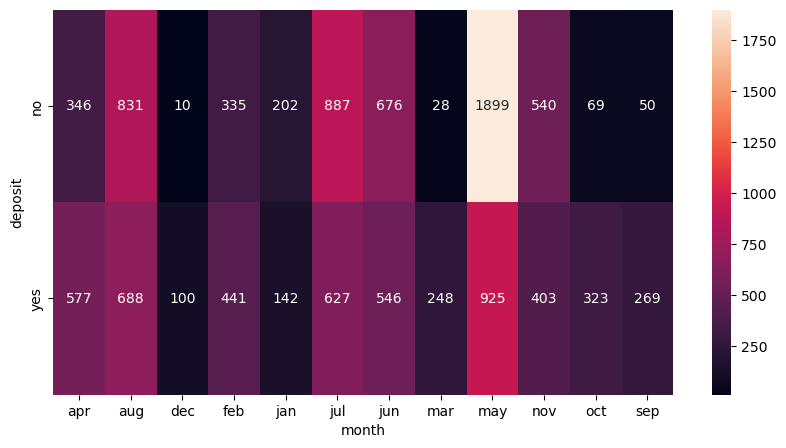

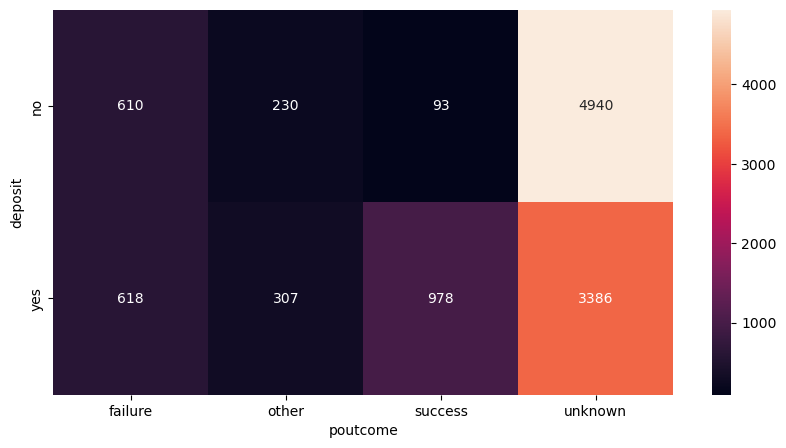

In [10]:
# Conteos de las diferentes categorías de las columnas categóricas, agrupado por la columna "deposit"
for col in df.select_dtypes(include="object"):
    if col != "deposit":
        plt.figure(figsize=(10, 5))
        sns.heatmap(
            df.pivot_table(index="deposit", columns=col, values="age", aggfunc="count"),
            annot=True,
            fmt="d",
        )
        plt.show()

#### Conclusión:

De las variables categóricas, las que parecen tener una relación directa con nuestro objetivo son:

- default: las personas que han caido en impago tienen menos probabilidad de adquirir un depósito a término. Las personas buena paga están uniformemente distribuidas.
- housing: las personas que tienen un préstamos hipotecario tienen menos probabilidad de adquirir un depósito. Las personas sin préstamo tienen más probabilidad.
- loan: las personas que tienen un préstamo personal tienen menos probabilidad de adquirir un depósito. Las personas sin préstamo están uniformemente distribuidas.
- month: las personas que fueron contactadas en marzo, septiembre, octubre y diciembre tienen más probabilidad de adquirir un depósito. Las personas contactadas en mayo tienen menos probabilidad de adquirir un depósito. En los demás meses la distribución es uniforme.
- poutcome: las personas que aceptaron una campaña publicitaria en el pasado tienen mucha más probabilidad de volverla a aceptar. En los demás casos, la distribución es uniforme.

## 3. Preprocesamiento

Antes de continuar al modelamiento, hagamos las siguientes operaciones:

In [11]:
# Versión numérica de la columna "deposit"
df["deposit_num"] = df["deposit"].map({"no": 0, "yes": 1})
df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_num
9915,31,technician,single,tertiary,no,-749,yes,yes,cellular,29,jul,82,4,-1,0,unknown,no,0
9222,42,blue-collar,divorced,primary,no,419,yes,yes,unknown,14,may,96,4,-1,0,unknown,no,0
4888,32,technician,divorced,tertiary,no,53,no,no,cellular,22,aug,671,2,-1,0,unknown,yes,1
111,34,blue-collar,married,secondary,no,1207,yes,no,unknown,21,may,905,1,-1,0,unknown,yes,1
3396,33,management,single,tertiary,no,718,yes,no,cellular,6,apr,122,1,98,2,success,yes,1
2428,48,management,married,tertiary,no,1147,no,no,cellular,5,aug,389,1,64,2,success,yes,1
2310,60,management,married,secondary,no,544,no,no,cellular,12,jun,95,7,357,2,failure,yes,1
10610,50,admin.,married,secondary,no,1138,yes,yes,cellular,31,jul,73,8,-1,0,unknown,no,0
428,25,blue-collar,single,primary,no,2483,no,no,cellular,10,jul,1499,3,-1,0,unknown,yes,1
4361,60,retired,married,secondary,no,523,no,no,cellular,13,aug,192,3,-1,0,unknown,yes,1


In [12]:
# Estandarización de las columnas numéricas
numeric_cols = ["balance", "pdays", "previous"]
df[[f"{col}_std" for col in numeric_cols]] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()
df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,deposit,deposit_num,balance_std,pdays_std,previous_std
9369,57,blue-collar,married,primary,no,23,yes,no,telephone,31,...,25,8,-1,0,unknown,no,0,-0.466774,-0.481162,-0.363244
340,57,management,married,tertiary,no,9103,no,yes,unknown,20,...,1098,2,-1,0,unknown,yes,1,2.348369,-0.481162,-0.363244
5059,32,admin.,married,secondary,no,1604,no,yes,cellular,7,...,625,1,-1,0,unknown,yes,1,0.023396,-0.481162,-0.363244
1205,26,services,single,tertiary,no,1140,yes,no,cellular,6,...,984,2,-1,0,unknown,yes,1,-0.120462,-0.481162,-0.363244
3004,79,retired,married,secondary,no,8304,no,no,cellular,9,...,456,2,275,9,success,yes,1,2.100649,2.056575,3.563446
5479,47,unemployed,single,tertiary,no,2500,no,no,cellular,30,...,240,1,-1,0,unknown,no,0,0.301190,-0.481162,-0.363244
9850,33,admin.,single,tertiary,no,867,yes,no,cellular,14,...,247,1,-1,0,unknown,no,0,-0.205102,-0.481162,-0.363244
4976,59,admin.,married,secondary,no,0,yes,no,cellular,10,...,982,1,-1,0,unknown,yes,1,-0.473905,-0.481162,-0.363244
3739,36,management,divorced,tertiary,no,1057,no,no,cellular,19,...,230,2,164,2,failure,yes,1,-0.146195,1.035963,0.509354
7849,28,blue-collar,married,secondary,no,948,yes,no,unknown,9,...,455,1,-1,0,unknown,no,0,-0.179989,-0.481162,-0.363244


## 4. Regresor logístico Bayesiano

Comencemos con una implementación muy simple, tomando en cuenta solamente las variables numéricas.

Los regresores logísticos se parecen bastante a los regresores lineales. En este caso, al ser un problema de clasificación binaria, nuestra salida ("deposit") la modelamos con una distribución Bernoulli.

$$
deposit_i \sim \text{Bernoulli}(p_i).
$$

La probabilidad, es la que dependerá de los predictores ("balance", "pdays" y "previous"). Sabemos que la probabilidad debe de estar entre 0 y 1, por lo que usamos la función logit para asegurar esto:

$$
\text{logit}(p_i) = \log \frac{p_i}{1 - p_i}.
$$

Es sobre $\text{logit}(p_i)$ que definimos un modelo lineal de los predictores:

$$
\text{logit}(p_i) = \alpha + \beta_{balance}balance_i + \beta_{pdays}pdays_i + \beta_{previous}previous_i.
$$

Para los parámetros $\alpha$, $\beta_{balance}$, $\beta_{pdays}$, y $\beta_{previous}$ definimos previas. El modelo queda como sigue:

$$
\begin{align}
\begin{array}{lcl}
deposit_i & \sim & \text{Bernoulli}(p_i) \\
\text{logit}(p_i) & = & \alpha + \beta_{balance}balance_i + \beta_{pdays}pdays_i + \beta_{previous}previous_i \\
\alpha & \sim & \text{Normal}(0, 1) \\
\beta_{balance} & \sim & \text{Normal}(0, 1) \\
\beta_{pdays} & \sim & \text{Normal}(0, 1) \\
\beta_{previous} & \sim & \text{Normal}(0, 1) \\
\end{array}
\end{align}
$$

In [13]:
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az
# Importar numpy
import numpy as np

In [14]:
# Modelo solo con variables numéricas
balance = df["balance_std"].values
pdays = df["pdays_std"].values
previous = df["previous_std"].values
deposit = df["deposit_num"].values
with pm.Model() as only_numeric:
    # Previas
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_balance = pm.Normal("beta_balance", mu=0, sigma=1)
    beta_pdays = pm.Normal("beta_pdays", mu=0, sigma=1)
    beta_previous = pm.Normal("beta_previous", mu=0, sigma=1)
    # Regresión
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            alpha
            + beta_balance * balance
            + beta_pdays * pdays
            + beta_previous * previous
        ),
    )
    # Deposit
    deposit = pm.Bernoulli("deposit", p=p, observed=deposit)

### Simulación predictiva previa

Veamos que tan buenas son estas previas que elegimos:

In [15]:
# Simulación predictiva previa
with only_numeric:
    prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, beta_balance, beta_pdays, beta_previous, deposit]


In [16]:
df.shape

(11162, 21)

In [17]:
# Objeto prior predictive
prior_predictive.prior["p"]

<xarray.DataArray 'p' (chain: 1, draw: 500, p_dim_0: 11162)> Size: 45MB
array([[[0.59141362, 0.40139126, 0.5026297 , ..., 0.40010464,
         0.47670188, 0.39777616],
        [0.41747081, 0.55116363, 0.47958478, ..., 0.55209104,
         0.74118834, 0.55377104],
        [0.70078976, 0.71785029, 0.70882934, ..., 0.71796699,
         0.30010784, 0.71817843],
        ...,
        [0.74282089, 0.73822136, 0.74067984, ..., 0.73818915,
         0.51629698, 0.73813077],
        [0.78219325, 0.62292387, 0.71420935, ..., 0.62165309,
         0.05657847, 0.61934554],
        [0.12094434, 0.35702335, 0.20881961, ..., 0.35925642,
         0.62309839, 0.36331938]]])
Coordinates:
  * chain    (chain) int32 4B 0
  * draw     (draw) int32 2kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * p_dim_0  (p_dim_0) int32 45kB 0 1 2 3 4 5 ... 11157 11158 11159 11160 11161

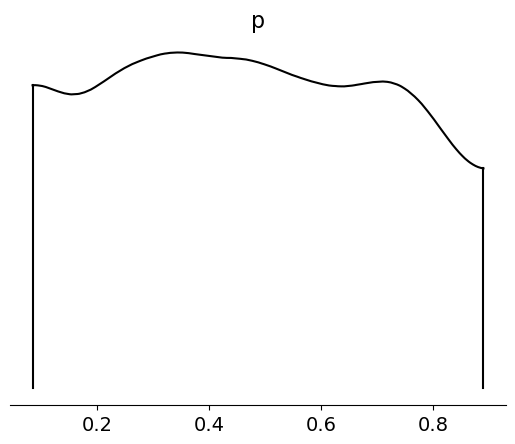

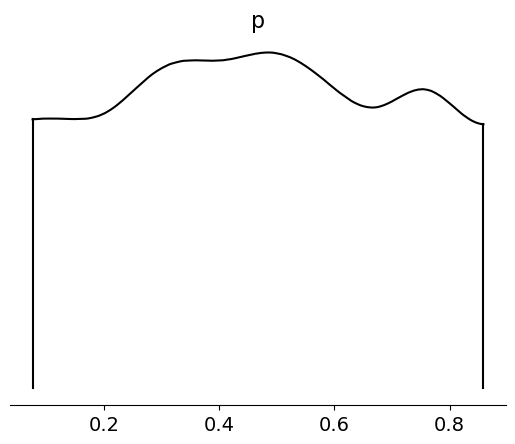

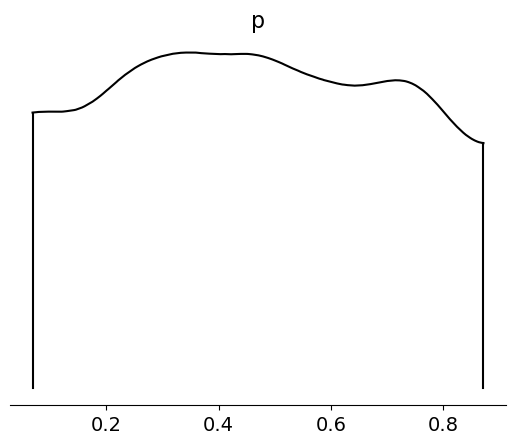

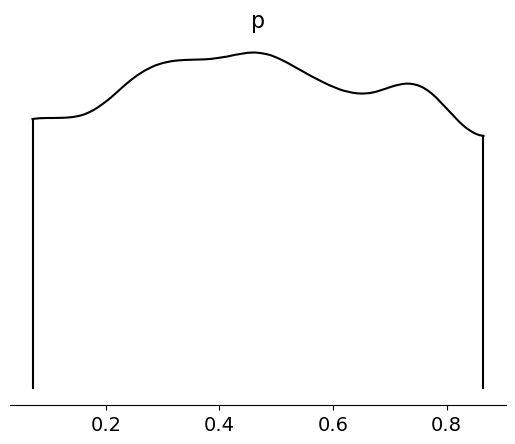

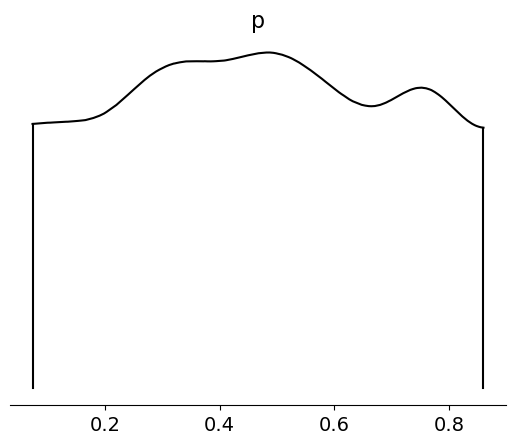

In [18]:
# Generemos algunas de las densidades previas para algunos sujetos
for i in np.random.randint(0, df.shape[0], 5):
    az.plot_density(
        prior_predictive.prior["p"].sel(p_dim_0=i),
        colors=["k"],
        var_names="p",
        point_estimate=None,
    )

Las previas elegidas parecen hacer un buen trabajo, en el sentido de que las probabilidades no se cargan a 0 o a 1.

### Resultados e interpretación

Generemos muestras de la distribución posterior:

In [19]:
# Muestreo de la distribución posterior
with only_numeric:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_balance, beta_pdays, beta_previous]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


Veamos las posteriores para las $\beta$ s:

array([<Axes: title={'center': 'beta_balance'}>,
       <Axes: title={'center': 'beta_pdays'}>,
       <Axes: title={'center': 'beta_previous'}>], dtype=object)

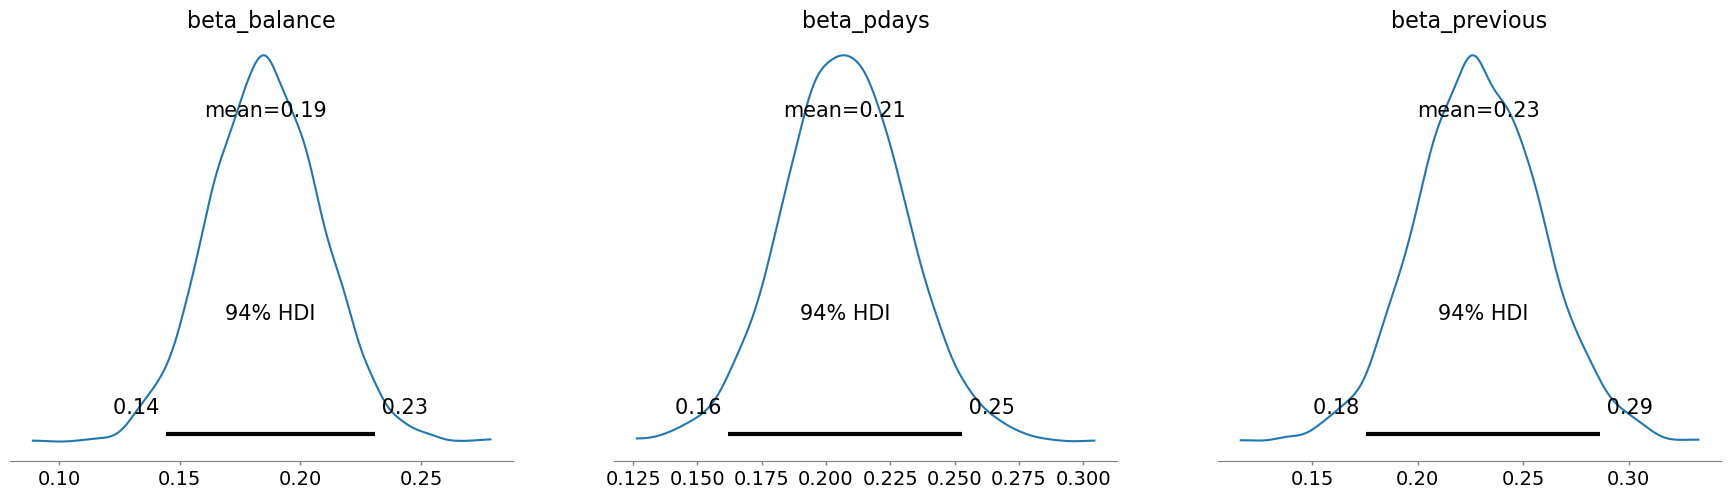

In [20]:
# az.plot_posterior
az.plot_posterior(
    idata,
    var_names=["beta_balance", "beta_pdays", "beta_previous"],
)

Observamos que en conjunto las tres variables, en efecto tienen una relación positiva en la probabilidad de que un sujeto adquiera un depósito.

Es importante recordar que el espacio en el que están estas $\beta$ s, es un espacio transformado por la transformación logística inversa.

Para $\alpha$, debido a que estandarizamos nuestras variables, sabemos que $\text{logit}(p) = \alpha$ es la probabilidad de que un sujeto con balance, pdays y previous promedios acepte un depósito.

In [21]:
# Importar scipy.special.expit as logistic
from scipy.special import expit as logistic

<Axes: title={'center': 'alpha'}>

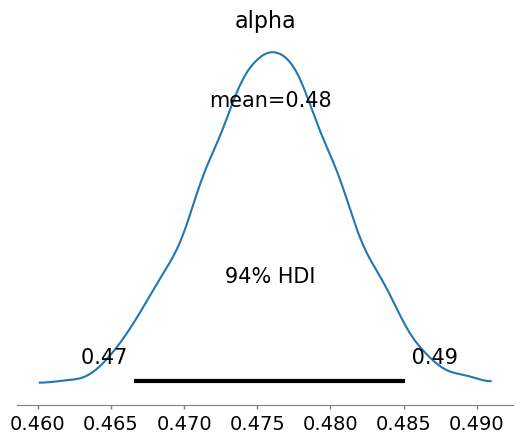

In [22]:
# az.plot_posterior
az.plot_posterior(
    idata,
    var_names=["alpha"],
    transform=logistic
)

La probabilidad de que un sujeto promedio acepte un depósito está entre 0.47 y 0.48.

### Evaluación del modelo

Comenzamos por hacer una partición de los datos:

In [26]:
# Importar train_test_split
from sklearn.model_selection import train_test_split

In [27]:
# Partición de los datos en entrenamiento y prueba
X = df[["balance_std", "pdays_std", "previous_std"]]
y = df["deposit_num"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Redefinimos el modelo usando variables mutables, con los datos de entrenamiento:

In [30]:
# Redefinimos modelo con variables mutables
with pm.Model() as only_numeric_mutable:
    # Variables numéricas mutables
    balance = pm.MutableData("balance", X_train["balance_std"].values, dims="obs")
    pdays = pm.MutableData("pdays", X_train["pdays_std"].values, dims="obs")
    previous = pm.MutableData("previous", X_train["previous_std"].values, dims="obs")
    deposit_data = pm.MutableData("deposit_data", y_train.values, dims="obs")
    # Previas
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_balance = pm.Normal("beta_balance", mu=0, sigma=1)
    beta_pdays = pm.Normal("beta_pdays", mu=0, sigma=1)
    beta_previous = pm.Normal("beta_previous", mu=0, sigma=1)
    # Regresión
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            alpha
            + beta_balance * balance
            + beta_pdays * pdays
            + beta_previous * previous
        ),
    )
    # Deposit
    deposit = pm.Bernoulli("deposit", p=p, observed=deposit_data, dims="obs")

Muestreamos la distribución posterior:

In [32]:
# Muestreo de la distribución posterior
with only_numeric_mutable:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_balance, beta_pdays, beta_previous]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


Para los datos observados, muestreamos la distribución posterior predictiva:

In [33]:
# Cambiamos los datos observados y muestreamos la distribución posterior predictiva
with only_numeric_mutable:
    pm.set_data(
        {
            "balance": X_test["balance_std"].values,
            "pdays": X_test["pdays_std"].values,
            "previous": X_test["previous_std"].values,
            "deposit_data": y_test.values,
        },
        coords={"obs": X_test.index},
    )
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [deposit]


In [35]:
X_test.index

Index([ 5527,  4541,  1964,  5007,  8928,  8936,  6141,  8786,  8697,  8582,
       ...
       10330,  5066,   750,  4721,  4127,   376,  5544, 10749,  3881,  6786],
      dtype='int64', length=2233)

Observamos la posterior predictiva:

In [34]:
# Tenemos 4 cadenas, 1000 muestras por cadena y 2233 sujetos de prueba
idata.posterior_predictive["deposit"]

<xarray.DataArray 'deposit' (chain: 4, draw: 1000, obs: 2233)> Size: 71MB
array([[[1, 1, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 1, 1],
        [0, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 1, 0, 0]],

       [[1, 0, 1, ..., 0, 1, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 1, ..., 1, 1, 0],
        ...,
        [1, 0, 0, ..., 1, 1, 1],
        [0, 1, 1, ..., 1, 1, 0],
        [1, 0, 0, ..., 0, 1, 1]],

       [[0, 1, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 0, 1],
        [0, 0, 1, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 1, 1, 1],
        ...,
        [1, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 1, 1]]], dtype=int64)
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs      (obs) int32 9kB 5527 4541 1964 5007 8928 ... 5544 10749 3881 6786

In [36]:
# Tomamos promedio sobre las cadenas y las muestras
y_score = idata.posterior_predictive["deposit"].mean(dim=["chain", "draw"])
y_score

<xarray.DataArray 'deposit' (obs: 2233)> Size: 18kB
array([0.4285 , 0.44175, 0.641  , ..., 0.6035 , 0.724  , 0.7195 ])
Coordinates:
  * obs      (obs) int32 9kB 5527 4541 1964 5007 8928 ... 5544 10749 3881 6786

Con lo anterior, llevamos a cabo la evaluación, eligiendo el mejor threshold para maximizar el f1:

In [37]:
# Importamos precision_recall_curve y f1_score
from sklearn.metrics import precision_recall_curve, f1_score

In [39]:
# Construimos la curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_score)
pr_curve = pd.DataFrame({"precision": precision, "recall": recall, "thresholds": np.concatenate([[0], thresholds])})
pr_curve

,precision,recall,thresholds
0,0.477833,1.000000,0.00000
1,0.478047,1.000000,0.32775
2,0.478261,1.000000,0.37950
3,0.478475,1.000000,0.38275
4,0.478690,1.000000,0.38375
...,...,...,...
796,0.600000,0.002812,0.90175
797,0.500000,0.001874,0.93650
798,0.666667,0.001874,0.93725
799,1.000000,0.000937,0.98575


In [40]:
# Construimos la curva F1 vs. umbrales
f1 = pd.Series({t: f1_score(y_true=y_test, y_pred=y_score > t) for t in thresholds})
# Encontramos el umbral que maximiza F1
best_threshold = f1.idxmax()
best_threshold

0.398

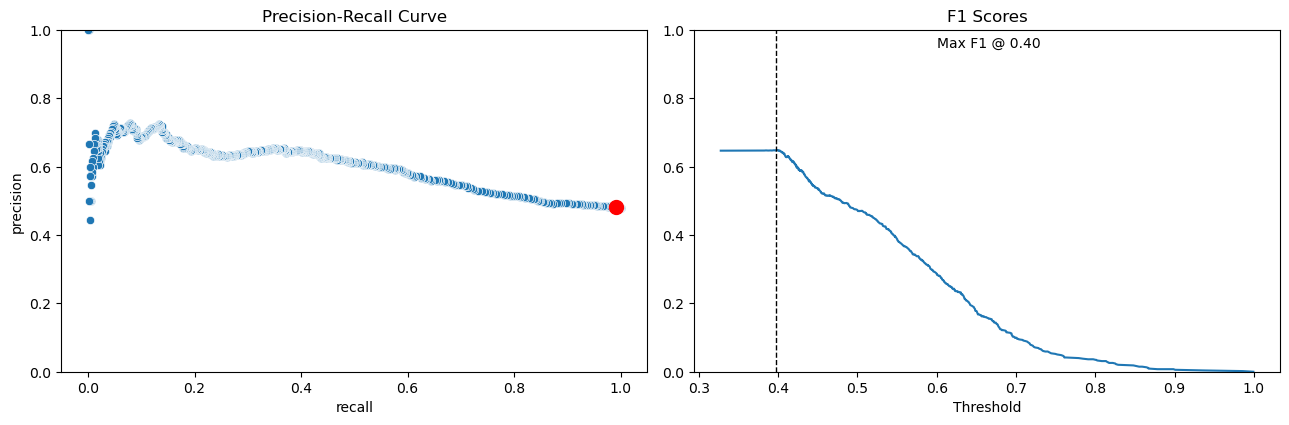

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))

# Curva Precision-Recall, con el mejor umbral marcado
sns.scatterplot(x='recall', y='precision', data=pr_curve, ax=axes[0])
axes[0].plot(
    pr_curve.loc[np.where(thresholds == best_threshold)[0], 'recall'],
    pr_curve.loc[np.where(thresholds == best_threshold)[0], 'precision'],
    'ro',
    ms=10
)
axes[0].set_ylim(0,1)
axes[0].set_title('Precision-Recall Curve')

# Curva F1 vs. umbrales, con el mejor umbral marcado
f1.plot(ax=axes[1], title='F1 Scores', ylim=(0,1))
axes[1].set_xlabel('Threshold')
axes[1].axvline(best_threshold, lw=1, ls='--', color='k')
axes[1].text(x=.60, y=.95, s=f'Max F1 @ {best_threshold:.2f}')
fig.tight_layout()
plt.subplots_adjust(top=.8)
plt.show();

In [43]:
pr_curve[pr_curve["thresholds"] == best_threshold]

,precision,recall,thresholds
26,0.482005,0.991565,0.398


In [44]:
# Accuracy
accuracy = (y_test == (y_score > best_threshold)).mean()
accuracy

0.4867890729959696

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>